In [1]:
import sys
import os
import tensorflow as tf
from deepface import DeepFace
import numpy as np
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import json
import base64
from io import BytesIO
import time


Extracting faces...
Detection time 20.971295833587646s 

Comparing faces
Person: 1/19
Analyzing the person aparicio-azner
Extracting reference face...
Comparing faces...
100.000%
Face comparison time 13.153097867965698s

Person: 2/19
Analyzing the person ayala-javier
Extracting reference face...
Comparing faces...
100.000%
Face comparison time 2.969651222229004s

Person: 3/19
Analyzing the person bernal-jaime
Extracting reference face...
Comparing faces...
100.000%
Face comparison time 4.29538106918335s

Person: 4/19
Analyzing the person caballero-luis
Extracting reference face...
Comparing faces...
100.000%
Face comparison time 4.662580490112305s

Person: 5/19
Analyzing the person delatorre-pedro
Extracting reference face...
Comparing faces...
100.000%
Face comparison time 2.888295888900757s

Person: 6/19
Analyzing the person diaz-julian
Extracting reference face...
Comparing faces...
100.000%
Face comparison time 2.885361671447754s

Person: 7/19
Analyzing the person freitas-jeremy
Ex

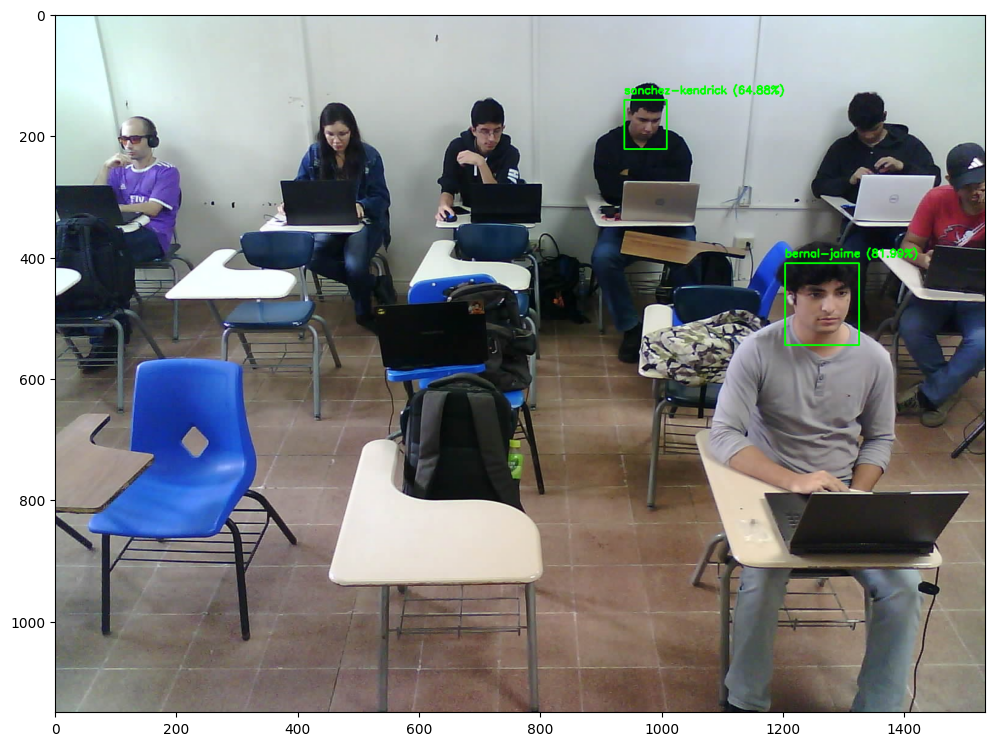

In [2]:
#FUNCIONES UTILES
def get_person_dict(targetname:str, list_dict:list)->dict:
    for person_dict in list_dict:
        if person_dict["name"] == targetname:
            return person_dict
    return None

def extract_pixels_from_image(image: np.ndarray, facial_area: dict) -> np.ndarray:
    """
    Extrae el área de la imagen basado en las coordenadas de 'facial_area' y devuelve
    el recorte como un array en formato float64.

    Args:
        image (np.ndarray): Imagen original cargada con OpenCV en formato uint8 BGR.
        facial_area (dict): Diccionario con las coordenadas 'x', 'y', 'w', 'h'.

    Returns:
        np.ndarray: El recorte del rostro en formato float64 y en el rango [0, 1].
    """
    x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
    
    # Ajustar las coordenadas para evitar índices negativos
    x = max(0, x)
    y = max(0, y)
    
    # Recortar la imagen en la región del área facial
    face_crop = image[y:y+h, x:x+w]

    # Convertir el recorte a float64 y escalar a [0, 1]
    face_crop_float64 = face_crop.astype(np.float64) / 255.0
    
    return face_crop_float64

def extract_and_expand_faces(img_path: str, margin_ratio: float = 0.0) -> list:
    """
    Extrae rostros de una imagen y expande los bounding boxes según el margin_ratio.
    Args:
        img_path (str): Ruta de la imagen para procesar.
        margin_ratio (float): Proporción de expansión del bounding box. 
    Returns:
        List[Dict[str, Any]]: Lista de rostros detectados con bounding boxes ajustados.
    """
    # Cargar la imagen
    image = cv2.imread(img_path)

    # Detectar rostros con DeepFace usando el modelo RetinaFace
    faces = DeepFace.extract_faces(
        img_path=image,
        detector_backend='retinaface',
        enforce_detection=False
    )

    # Expande los bounding boxes
    for face_data in faces:
        facial_area = face_data['facial_area']
        
        # Obtener coordenadas originales
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
        
        # Calcular margen adicional basado en el ratio
        margin_x = int(w * margin_ratio)
        margin_y = int(h * margin_ratio)
        
        # Expande el bounding box con el margen calculado
        facial_area['x'] = x - margin_x
        facial_area['y'] = y - margin_y
        facial_area['w'] = w + 2 * margin_x
        facial_area['h'] = h + 2 * margin_y

    for __face__ in faces:
        __face__['face'] = extract_pixels_from_image(image, __face__['facial_area'])
    
    return faces

def get_img_array_uint8(arraydata):
    img = arraydata
    #B, G, R = img.T
    #__bgr_img = np.array((B, G, R)).T
    #bgr_img = (__bgr_img*255).astype(np.uint8)
    bgr_img = (img*255).astype(np.uint8)
    return bgr_img

def get_people_list(path_people_ref:str)->list:
    # Ruta del directorio de referencia
    ref_directory = path_people_ref

    # Lista para almacenar los diccionarios de las personas
    list_dict = []

    # Recorrer cada subdirectorio en el directorio de referencia
    for person_name in os.listdir(ref_directory):
        person_path = os.path.join(ref_directory, person_name)
    
        # Verificar si es un directorio (nombre de persona)
        if os.path.isdir(person_path):
            # Listar las imágenes dentro del subdirectorio de la persona
            images = [img for img in os.listdir(person_path) if img.endswith(".png")]
            
            # Generar rutas completas con "/" como separador
            image_paths = [os.path.join(person_path, img).replace("\\", "/") for img in images]
        
            # Crear el diccionario para esta persona
            person_dict = {
                "name": person_name,
                "images": images,
                "images_paths": image_paths
            }
        
            # Añadir a la lista
            list_dict.append(person_dict)
    
    return list_dict

def draw_person_face(image, refined_matches):
    """
    Dibuja los recuadros en la imagen basados en los resultados de la verificación refinados.

    Args:
        image (np.ndarray): Imagen original en formato BGR.
        refined_matches (list): Lista refinada de coincidencias por rostro.

    Returns:
        np.ndarray: Imagen con recuadros y etiquetas dibujadas.
    """
    for match in refined_matches:
        if not match or len(match) == 0:  # Ignorar entradas vacías
            continue

        # Extraer la información del match
        match = match[0]  # Tomar el mejor match después de aplicar la heurística
        name_person = match['name_person']
        confidence = (1.0 - match['distance']) * 100  # Convertir a porcentaje
        facial_area = match['facial_area']

        # Coordenadas del área facial
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

        # Definir el color del recuadro (verde para rostros verificados)
        color = (0, 255, 0)

        # Etiqueta con el nombre y confianza
        label = f"{name_person} ({confidence:.2f}%)"

        # Dibujar el recuadro
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

        # Dibujar el texto encima del recuadro
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return image

def heuristic_minimum_distance_matches(match_list_index):
    
    refined_matches:list = match_list_index.copy()

    # 1. Falso positivo multiple collisions select minimum distance
    for i in range(len(refined_matches)):
       if len(refined_matches[i]) > 1:  # Si hay más de un match en el índice
        #encontrar el dict con el menor 'distance'
        refined_matches[i].sort(key=lambda x: x['distance'])  
        best_match = refined_matches[i][0]  
        refined_matches[i] = [best_match]
           
    # 2. Falso positivo de identidad cruzada: seleccionar la menor distancia
    for i in range(len(refined_matches)):
        if len (refined_matches[i]) == 0:
            continue
        
        current_name:str = refined_matches[i][0]['name_person']
        index_cross_collision = []  # Almacena índices con el mismo nombre
        
        #Buscar colisiones con el mismo nombre
        for j in range(i, len(refined_matches)):
            if refined_matches[j] and current_name == refined_matches[j][0]['name_person']:
                index_cross_collision.append(j)
    
        #si hay colisiones (mas de un indice con el mismo nombre)
        if len(index_cross_collision) > 1:
            #seleccionar el indice con la menor distancia
            min_distance_index = min(index_cross_collision, key=lambda x: refined_matches[x][0]['distance'])
            #mantener solo el indice con la menor distancia, borrar el resto
            for k in index_cross_collision:
                if k != min_distance_index:
                    refined_matches[k] = []  # Marcar como eliminado

    return refined_matches

def heuristic_unknown_faces(
    match_list_index:list, 
    minimum_match_list_index:list, 
    faces_data:list, 
    list_dict_people:list, 
    percentage_low:float=0.64, 
    percentage_high:float=0.75,
    threshold:float=0.398,
    min_positive_matches:int=2
)->list:
    """
    Analiza rostros desconocidos y asigna una identidad probable utilizando referencias adicionales.

    Args:
        refined_match_list_index (list): Lista refinada de coincidencias por índice.
        minimum_match_list_index (list): Lista con la distancia mínima para cada índice.
        faces_data (list): Lista de datos de rostros detectados.
        dict_person_images (dict): Diccionario con nombres de personas y sus imágenes de referencia.
        threshold_low (float): Umbral inferior para considerar un resultado positivo.
        threshold_high (float): Umbral superior para considerar una alta confianza.
        min_positive_matches (int): Mínimo número de coincidencias en el rango de confianza.

    Returns:
        list: Lista refinada con posibles asignaciones para rostros desconocidos.
    """
    
    refined_matches = match_list_index.copy()

    for i in range(len(refined_matches)):
        
        if len(refined_matches[i]) == 0:  # Rostros desconocidos
            
            candidate = minimum_match_list_index[i]
            if not candidate:
                continue  # No hay candidato disponible para este índice
            
            candidate_name = candidate['name_person']
            candidate_scores = []
            candidate_dict = get_person_dict(candidate_name,list_dict_people)
            candidate_result_dict:dict = None
            
            # Verificar con imágenes adicionales
            
            if candidate_dict:
                total_images:int = len(candidate_dict['images_paths'])
                j:int = 0
                print("\nVerifying the identity of",candidate_name)
                for ref_img_path in candidate_dict['images_paths']:
                    loading:str = f"{((j+1)/(total_images)) * 100:.3f}%"
                    print("\r" + loading, end="")
                    ref_face_data = extract_and_expand_faces(ref_img_path, 0.18)
                    candidate_result_dict = compare_two_faces(faces_data[i], ref_face_data[0], candidate_name, metric_threshold=threshold)
                    if candidate_result_dict:  # Si hay un resultado
                        candidate_scores.append(1.0 - candidate_result_dict['distance'])
                    j+=1
            
            # Aplicar la heurística de verificación
            positive_matches = sum(1 for score in candidate_scores if (percentage_low <= score <= percentage_high))
            high_confidence = any(score > percentage_high for score in candidate_scores)
            
            if positive_matches >= min_positive_matches or high_confidence:
                refined_matches[i] = [{
                    "index": i,
                    "distance": candidate_result_dict["distance"],
                    "threshold":candidate_result_dict['threshold'],
                    "verified": True,
                    "name_person": candidate_name,
                    "facial_area": candidate_result_dict['facial_area']
                }]
            else:
                refined_matches[i] = []
    
    return refined_matches

def recognize_person(
    analyze_faces: list, 
    ref_face: list,
    name_person: str,
    metric_model_name: str = "Facenet512",
    metric_distance: str = "cosine",
    metric_threshold: float = 0.4
) -> list:
    """
    Reconoce a una persona comparando los rostros detectados en la imagen de análisis
    con el rostro de referencia, utilizando DeepFace.

    Args:
        analyze_faces (list): Lista de rostros detectados en la imagen de análisis.
        ref_face (list): Lista con el rostro objetivo (referencia).
        analyze_margin_ratio (float): Margen de expansión para los rostros analizados.
        ref_margin_ratio (float): Margen de expansión para el rostro de referencia.
        metric_model_name (str): Modelo a utilizar para la comparación.
        metric_distance (str): Métrica de distancia para la comparación.
        metric_threshold (float): Umbral para verificar si los rostros coinciden.

    Returns:
        list: Lista de diccionarios con información de los resultados para cada rostro.
    """
    if not ref_face or len(ref_face) == 0:
        print("Error: The reference face is empty.")
        return []
    
    # Obtener el rostro de referencia
    target_face_data = ref_face[0]
    target_face = target_face_data['face']
    array_bgr_target_face = (target_face * 255.0).astype(np.uint8)

    results = []
    total_faces = len(analyze_faces)

    # Iterar sobre cada rostro detectado en la imagen de análisis
    for i, face_data in enumerate(analyze_faces):
        # Progreso de la comparación
        loading = f"{((i+1) / (total_faces)) * 100:.3f}%"
        print("\r" + loading, end="")

        facial_area = face_data['facial_area']  # Bounding box
        face = face_data['face']
        array_bgr_face = (face * 255.0).astype(np.uint8)

        # Comparar el rostro detectado con el rostro de referencia
        result = DeepFace.verify(
            img1_path=array_bgr_target_face,
            img2_path=array_bgr_face,
            detector_backend="skip",
            model_name=metric_model_name,
            distance_metric=metric_distance,
            threshold=metric_threshold,
            enforce_detection=False
        )

        # Almacenar los resultados
        results.append({
            "index": i,
            "distance": result['distance'],
            "threshold": result['threshold'],
            "verified": result['verified'],
            "name_person": name_person,
            "facial_area": facial_area
        })

    # Ordenar resultados por distancia
    results.sort(key=lambda x: x['distance'])

    # Imprimir resultados ordenados
    #for res in results:
        #print(f"Index: {res['index']} Distance: {res['distance']:.4f}")

    return results

def compare_two_faces(
    unknown_face: dict, 
    ref_face: dict,
    name_person: str,
    metric_model_name: str = "Facenet512",
    metric_distance: str = "cosine",
    metric_threshold: float = 0.4
) -> dict:
    """
    Compara un rostro desconocido con un rostro de referencia utilizando DeepFace.

    Args:
        unknown_face (dict): Diccionario con los datos del rostro desconocido.
        ref_face (dict): Diccionario con los datos del rostro de referencia.
        name_person (str): Nombre de la persona de referencia.
        metric_model_name (str): Modelo a utilizar para la comparación.
        metric_distance (str): Métrica de distancia para la comparación.
        metric_threshold (float): Umbral para verificar si los rostros coinciden.

    Returns:
        dict: Diccionario con información del resultado de la comparación.
    """
    if not ref_face or not unknown_face:
        print("Error: Missing face data.")
        return {}

    # Obtener los rostros procesados
    target_face = ref_face['face']
    unknown_face_img = unknown_face['face']

    # Convertir los rostros a formato BGR uint8
    array_bgr_target_face = (target_face * 255.0).astype(np.uint8)
    array_bgr_unknown_face = (unknown_face_img * 255.0).astype(np.uint8)

    # Comparar los dos rostros
    result = DeepFace.verify(
        img1_path=array_bgr_target_face,
        img2_path=array_bgr_unknown_face,
        detector_backend="skip",
        model_name=metric_model_name,
        distance_metric=metric_distance,
        threshold=metric_threshold,
        enforce_detection=False
    )

    # Construir el resultado
    comparison_result = {
        "distance": result['distance'],
        "threshold": result['threshold'],
        "verified": result['verified'],
        "name_person": name_person,
        "facial_area": unknown_face['facial_area']
    }

    return comparison_result

def generate_results_json(match_list:list, faces_data:list, image_with_faces) -> str:
    """
    Genera un JSON con los resultados de las coincidencias de detección facial.
    
    Args:
        match_list (list): Lista de resultados refinados por índice.
        faces_data (list): Lista de datos originales de los rostros extraídos.
        image_with_faces (np.ndarray): Imagen con los recuadros dibujados.
    
    Returns:
        str: JSON en formato string con la estructura solicitada.
    """
    detected = []
    unknown = []
    
    # Codificar la imagen con rostros en Base64
    _, buffer = cv2.imencode('.jpg', image_with_faces)
    encoded_image = base64.b64encode(buffer).decode('utf-8')
    
    # Procesar la lista de matches
    for i, matches in enumerate(match_list):
        if matches:  # Rostros Verificados
            detected.append({
                "index": i,
                "name_person": matches[0]['name_person'],
                "distance": matches[0]['distance'],
                "threshold": matches[0]['threshold'],
                "verified": matches[0]['verified'],
                "facial_area": matches[0]['facial_area']
            })
        else:  # Rostros no verificados (unknown)
            unknown.append({
                "index": i,
                "facial_area": faces_data[i]['facial_area'],
                "confidence": faces_data[i]['facial_area']
            })
    
    #crear el JSON final
    result_json = {
        "verified": detected,
        "pending": [],
        "unknown": unknown,
        "image": encoded_image
    }
    
    return json.dumps(result_json, indent=4)


#MAIN

#metrics = ["cosine", "euclidean", "euclidean_l2"]
#models  = ["Facenet", "Facenet512", "VGG-Face", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace","GhostFaceNet"]

#cargar la imagen a analizar


path_analyze_image = "./data/classroom/test/20241118115342.jpg"
#"./data/classroom/rawdata/s2/recording_2024-11-13_10-45-09/frame-248.jpg"
image = cv2.imread(path_analyze_image)

#extraer los rostros de la imagen a analizar
start_time = time.time()
print("Extracting faces...")
faces_data = extract_and_expand_faces(path_analyze_image, 0.2)
print(f"Detection time {(time.time()-start_time)}s \n")

#print(result_list_dict)
index:int = 0
image_with_verified_face = image
print("Comparing faces")
list_dict_people = get_people_list("./data/classroom/ref/")

match_list_index:list = []
minimum_match_list_index:list = []
for i in range(len(faces_data)):
    match_list_index.append([])
    minimum_match_list_index.append([])

start_time = time.time()

for dict_person in list_dict_people:

    t_start_time = time.time()
    
    print(f"Person: {index+1}/{len(list_dict_people)}")

    person_name:str = dict_person["name"]
    path_ref_img:str =  dict_person["images_paths"][0]
    print(f"Analyzing the person {person_name}")

    #extraer el rostro objetivo (face_target) de la imagen de referencia
    print("Extracting reference face...")
    target_face_data = extract_and_expand_faces(path_ref_img, 0.18)

    print("Comparing faces...")
    threshold = 0.385
    result_list_dict = recognize_person(faces_data, target_face_data, person_name, metric_threshold=threshold)
    
    print(f"\nFace comparison time {(time.time()-t_start_time)}s\n")

    #print("\nDrawing box...\n")        
    #image_with_verified_face = draw_verified_faces(image_with_verified_face, result_list_dict, name_person=person_name)

    for result in result_list_dict:
        idx = result['index']    
        #acumular en `match_list_index` si está verificado
        if result['verified']:
            match_list_index[idx].append(result)
        #actualizar la minima distancia en `minimum_match_list_index`
        if len(minimum_match_list_index[idx]) == 0:
            minimum_match_list_index[idx] = result
        else:
            if result['distance'] < minimum_match_list_index[idx]['distance']:
                minimum_match_list_index[idx] = result # Guardar el resultado con menor distancia

    index += 1

print(f"Comparison time {(time.time()-start_time)}s \n")

print("Computing heuristics for minor distance...")
refined_match_list_index = heuristic_minimum_distance_matches(match_list_index)

print("Computing heuristics for unknown faces...")
refined_match_list_index = heuristic_unknown_faces(refined_match_list_index, minimum_match_list_index, faces_data, list_dict_people, 0.64, 0.75, 0.385, 2)

print("\nComputing heuristics for minor distance...")
refined_match_list_index = heuristic_minimum_distance_matches(match_list_index)

print("\n")

for i in range(len(refined_match_list_index)):
    pname:str = "unknown"
    if len(refined_match_list_index[i]) > 0 :
        pname = refined_match_list_index[i][0]['name_person']
    print(f"Index {i} -> Faces {len(refined_match_list_index[i])} ({pname}) ")

#cargar la imagen original
origin_image = cv2.imread(path_analyze_image)
image_with_faces = draw_person_face(origin_image, refined_match_list_index)
image_rgb = cv2.cvtColor(image_with_faces, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(image_rgb)
plt.axis('on')
plt.show()

# Generar el JSON
#results_json = generate_results_json(refined_match_list_index, faces_data, image_with_faces)
